In [3]:
# imports
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import numpy as np
import random
import joblib
from sklearn import ensemble, feature_extraction, metrics, model_selection, pipeline, preprocessing
from collections import Counter
from boruta import BorutaPy
from IPython import display
from pyteomics import electrochem, mass, parser
%matplotlib inline
pd.options.display.max_rows = 10
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = 6

reading in boruta


## Variables

In [4]:
# positive (peptide) classes
peptides = ['EIYKRWII', 'FLKEKGGL']

# negative (control) class
negative = 'Control'

# all classes
classes = peptides + [negative]

# V and J gene as list
genes = ['V_gene', 'J_gene']

# amino acids
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
               'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',]

# physicochemical amino acid properties
basicity = {'A': 206.4, 'B': 210.7, 'C': 206.2, 'D': 208.6, 'E': 215.6, 'F': 212.1, 'G': 202.7,
            'H': 223.7, 'I': 210.8, 'K': 221.8, 'L': 209.6, 'M': 213.3, 'N': 212.8, 'P': 214.4,
            'Q': 214.2, 'R': 237.0, 'S': 207.6, 'T': 211.7, 'V': 208.7, 'W': 216.1, 'X': 210.2,
            'Y': 213.1, 'Z': 214.9}

hydrophobicity = {'A': 0.16, 'B': -3.14, 'C': 2.50, 'D': -2.49, 'E': -1.50, 'F': 5.00, 'G': -3.31,
                  'H': -4.63, 'I': 4.41, 'K': -5.00, 'L': 4.76, 'M': 3.23, 'N': -3.79, 'P': -4.92,
                  'Q': -2.76, 'R': -2.77, 'S': -2.85, 'T': -1.08, 'V': 3.02, 'W': 4.88, 'X': 4.59,
                  'Y': 2.00, 'Z': -2.13}

helicity = {'A': 1.24, 'B': 0.92, 'C': 0.79, 'D': 0.89, 'E': 0.85, 'F': 1.26, 'G': 1.15, 'H': 0.97,
            'I': 1.29, 'K': 0.88, 'L': 1.28, 'M': 1.22, 'N': 0.94, 'P': 0.57, 'Q': 0.96, 'R': 0.95,
            'S': 1.00, 'T': 1.09, 'V': 1.27, 'W': 1.07, 'X': 1.29, 'Y': 1.11, 'Z': 0.91}

mutation_stability = {'A': 13, 'C': 52, 'D': 11, 'E': 12, 'F': 32, 'G': 27, 'H': 15, 'I': 10,
                      'K': 24, 'L': 34, 'M':  6, 'N':  6, 'P': 20, 'Q': 10, 'R': 17, 'S': 10,
                      'T': 11, 'V': 17, 'W': 55, 'Y': 31}

physchems = {'basicity':basicity, 'hydrophobicity':hydrophobicity,
             'helicity':helicity, 'mutation stability':mutation_stability}


## Functions

In [5]:
def split_rows(df, column, symbol):
    
    ''' Given a dataframe, the name of a column in the dataframe and a symbol to split on:
    Split rows in two rows if that row's column value contains the symbol to split on.
    Each new row is identical to the original except for the column value which is replaced by one of its split parts.
    '''
    
    s = df[column].str.split(symbol, expand=True).stack()
    i = s.index.get_level_values(0)
    df2 = df.loc[i].copy()
    df2[column] = s.values
    return df2

def fix_gene_format(gene_string):
    
    ''' Make format in which V- and J-genes are encoded uniform and reduce to family level. '''
    if gene_string == 'unresolved':
        return gene_string
    if '-' in gene_string:
        gene_string = gene_string.split('-')[0]
    if len(gene_string) != 2:
        gene_string = '0'+gene_string
    return gene_string

def calc_average_property(sequence, physchem):
    return np.mean([physchem[x] for x in sequence])

## Reading and parsing input data

**TODO**: write explanation of source of data and preprocessing of it

In [6]:
# read peptide data
peptide_data = pd.read_csv('data.csv')
# J_genes don't contain double genes in the peptide dataset => only split on V_gene
peptide_data = split_rows(peptide_data, 'V_gene', '/') 

# read control data; splits were already done during processing of immuneaccess data
control_data = pd.read_csv('control_data.csv')

# combine control and peptide data
data = pd.concat([peptide_data, control_data], ignore_index=True)
for gene in genes:
    data[gene] = data[gene].apply(lambda x: fix_gene_format(x))

# show data
for target in classes:
    display.display(data[data['HLA_peptide'] == target])

,V_gene,CDR3_sequence,J_gene,HLA_peptide
0,27,CASSPNGDRVFDQPQHF,01,EIYKRWII
1,09,CASSVVGDGRETQYF,02,EIYKRWII
2,09,CASSEGQGTTYEQYF,02,EIYKRWII
3,02,CASSEAATGRGNQPQHF,01,EIYKRWII
4,09,CASSVLHGRQETQYF,02,EIYKRWII
...,...,...,...,...
137,28,CASSLPPPGIKGELFF,02,EIYKRWII
138,07,CASSTLPGTPRNEQYF,02,EIYKRWII
139,09,CASSVGGDARETQYF,02,EIYKRWII
140,02,CASSASTKDTQYF,02,EIYKRWII


,V_gene,CDR3_sequence,J_gene,HLA_peptide
142,02,CASSVLAGLGNEQFF,02,FLKEKGGL
143,02,CASSVLAGHGNGQFF,02,FLKEKGGL
144,11,CASSLLAGLTDTQYF,02,FLKEKGGL
145,02,CASSVLAGLGNEQFF,02,FLKEKGGL
146,02,CASSVLAGLGNEQFF,02,FLKEKGGL
...,...,...,...,...
232,07,CASSLAPGTSGSPYNEQFF,02,FLKEKGGL
233,14,CASSLGTGIANYGYTF,02,FLKEKGGL
234,14,CASSLGTGIANYGYTF,02,FLKEKGGL
235,24,CATKGTGLYNEQFF,02,FLKEKGGL


,V_gene,CDR3_sequence,J_gene,HLA_peptide
237,14,CASSPGESYEQYF,02,Control
238,14,CASSPSYRGEQYF,02,Control
239,14,CASSQWGTYEQYF,02,Control
240,14,CASSQTQFQPQHF,01,Control
241,14,CASSHLGGDEQFF,02,Control
...,...,...,...,...
58141,29,CSASTSGPETGNEQFF,02,Control
58142,29,CSASLVDAPMVNEQFF,02,Control
58143,29,CSAGTGGLGSNQPQHF,01,Control
58144,29,CTIARGTPLSTDTQYF,02,Control


In [ ]:
# show V_gene and J_gene usage
for gene in genes:
    bardfs = []
    for target in classes:
        bardfs.append(pd.DataFrame({'gene': data[(data['HLA_peptide']==target) & (data[gene]!='unresolved')][gene].value_counts(sort=False).index,
                              'count': data[(data['HLA_peptide']==target) & (data[gene]!='unresolved')][gene].value_counts(sort=False).values/data[data['HLA_peptide']==target][gene].value_counts(sort=False).values.sum(),
                              'peptide': [target for _ in data[(data['HLA_peptide']==target) & (data[gene]!='unresolved')][gene].value_counts(sort=False).index]}))
    bardf = pd.concat(bardfs)
    plt.figure()
    sns.barplot(x='gene', y='count', hue='peptide', data=bardf)
    plt.ylabel('frequency')

## Feature generation

Create features for each sequence based on:
* V-gene usage (one-hot)
* J-gene usage (one-hot)
* Sequence length (numerical)
* Amino acid count (numerical)
* Average amino acid properties (basicity, hydrophobicity, helicity, mutational stability) (numerical)
* Position specific amino acid properties (numerical)
* Position specific amino acid presence (one-hot)

In [52]:
def create_feature_matrix(data):

    # non-positional features
    nonpos_features_list = []

    # one-hot encode V- and J-gene
    onehot_encoder = feature_extraction.DictVectorizer(sparse=False)
    encoded_genes = pd.DataFrame(
            onehot_encoder.fit_transform(data[['V_gene', 'J_gene']].to_dict(orient='records')),
            columns=onehot_encoder.feature_names_)

    nonpos_features_list.append(pd.Series(data['CDR3_sequence'].apply(lambda x: len(x)), name='length'))

    # amount of each amino acid present in sequence
    aa_counts = []
    for aa in amino_acids:
        aa_counts.append(pd.Series(data['CDR3_sequence'].apply(lambda x: x.count(aa)), name='{} count'.format(aa)))
    nonpos_features_list.append(pd.concat(aa_counts, axis=1))

    # average physicochemical property value of sequence
    average_physchems = []
    for physchem_name, physchem in physchems.items():
        average_physchems.append(pd.Series(data['CDR3_sequence'].apply(lambda x: calc_average_property(x, physchem)), 
                                           name='average {}'.format(physchem_name)))
    nonpos_features_list.append(pd.concat(average_physchems, axis=1))
    
    # concatenate all non-positional features
    nonpos_features = pd.concat(nonpos_features_list, axis=1)
    
    # positional features
    pos_features_list = []
    
    # amino acid occurence and physicochemical properties at a given position from the center
    pos_aa, pos_basicity, pos_hydro, pos_helicity, pos_pI, pos_mutation = [[] for _ in range(6)]
    for sequence in data['CDR3_sequence']:
        length = parser.length(sequence)
        start_pos = -1 * (length // 2)
        pos_range = list(range(start_pos, start_pos + length)) if length % 2 == 1 else\
                    list(range(start_pos, 0)) + list(range(1, start_pos + length + 1))

        pos_aa.append({'pos_{}_{}'.format(pos, aa): 1
                       for pos, aa in zip(pos_range, sequence)})
        pos_basicity.append({'pos_{}_basicity'.format(pos): basicity[aa]
                             for pos, aa in zip(pos_range, sequence)})
        pos_hydro.append({'pos_{}_hydrophobicity'.format(pos): hydrophobicity[aa]
                          for pos, aa in zip(pos_range, sequence)})
        pos_helicity.append({'pos_{}_helicity'.format(pos): helicity[aa]
                             for pos, aa in zip(pos_range, sequence)})
        pos_pI.append({'pos_{}_pI'.format(pos): electrochem.pI(aa)
                       for pos, aa in zip(pos_range, sequence)})
        pos_mutation.append({'pos_{}_mutation_stability'.format(pos): mutation_stability[aa]
                             for pos, aa in zip(pos_range, sequence)})

    pos_features_list.append(pd.DataFrame.from_records(pos_aa).fillna(0))
    pos_features_list.append(pd.DataFrame.from_records(pos_basicity).fillna(0))
    pos_features_list.append(pd.DataFrame.from_records(pos_hydro).fillna(0))
    pos_features_list.append(pd.DataFrame.from_records(pos_helicity).fillna(0))
    pos_features_list.append(pd.DataFrame.from_records(pos_pI).fillna(0))
    pos_features_list.append(pd.DataFrame.from_records(pos_mutation).fillna(0))
    
    # concatenate all positional features
    pos_features = pd.concat(pos_features_list, axis=1)
    reindex_dict = {}
    for i, j in zip(pos_features.index, nonpos_features.index):
        reindex_dict[i]=j
    pos_features = pos_features.rename(index=reindex_dict)
    
    return pd.concat([nonpos_features, pos_features], axis=1)


## Data subsampling

In [53]:
class RandomSampler():
    
    ''' Generates k_samples tuples of indices to split dataframe into respectively:
    1) a dataframe containing n_pos_samples different positive samples
    2) a dataframe containing n_neg_samples different negative samples.
    Within each tuple, indices are drawn randomly without replacement.
    Between tuples, indices can reoccur. '''
    
    def __init__(self, n_pos_samples, n_neg_samples, k_samples = 10):
        
        # number of positive indices to generate
        self.n_pos_samples = n_pos_samples
        # number of negative indices to generate
        self.n_neg_samples = n_neg_samples
        # number of tuple indices to return
        self.k_samples = k_samples
        
    def split(self, y, pos_label, neg_label):
        
        indices = []
        for k in range(self.k_samples):
            all_pos_indices = y[y==pos_label].index
            selected_pos_indices = np.random.choice(all_pos_indices, size=self.n_pos_samples)
            all_neg_indices = y[y==neg_label].index
            selected_neg_indices = np.random.choice(all_neg_indices, size=self.n_neg_samples)
            indices.append(np.append(selected_pos_indices, selected_neg_indices))
        return indices
            

In [54]:
# number of positive and negative samples to include in subsampling
n_pos_samples = {pep: sum(data['HLA_peptide']==pep) for pep in peptides}
n_neg_samples = {pep: sum(data['HLA_peptide']==pep)*10 for pep in peptides}
k_samples = 5

# split dataframe into frame containing raw data and frame containing target
X_raw = data.drop('HLA_peptide', axis=1)
y = data['HLA_peptide']

# create subsamples from complete data and convert their raw data to the feature space
splitframes = []
for peptide in peptides:
    mysampler = RandomSampler(n_pos_samples = n_pos_samples[peptide], 
                              n_neg_samples = n_neg_samples[peptide], 
                              k_samples = k_samples)
    for indices in mysampler.split(y=y, pos_label=peptide, neg_label=negative):
        splitframes.append((peptide, create_feature_matrix(X_raw.iloc[indices]), y.iloc[indices]))

## Classification

In [55]:
# run a single iteration of the predictor (extracted to a method for multithreaded computation)
def run_predictor(predictor, X, y, train_index, test_index):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train the predictor pipeline
    predictor.fit(X_train, y_train)
    
    # extract the relevant feature importances
    importances = np.zeros(X.shape[1], float)
    importances[predictor.named_steps['feature_selection'].support_] =\
        predictor.named_steps['classification'].feature_importances_
    
    # return the predictions to evaluate the performance
    predictions_proba = predictor.predict_proba(X_test)[:, 1]
    return (y_test, np.array(predictions_proba > 0.5, np.int)),\
           (y_test, predictions_proba),\
           importances

In [56]:
# number of trees to use by RF
n_trees = 200

# create a prediction pipeline consisting of feature selection and classification
classifier = ensemble.RandomForestClassifier(n_trees, n_jobs=-1, random_state=0, class_weight='balanced')
feature_selection = BorutaPy(ensemble.ExtraTreesClassifier(n_jobs=-1), n_estimators='auto', random_state=0)

predictor = pipeline.Pipeline([('feature_selection', feature_selection), ('classification', classifier)])

Classification accuracy = 97.41% ± 0.42%


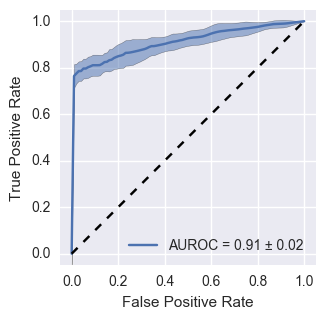

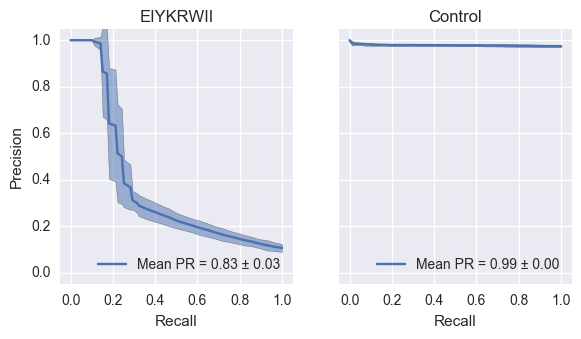

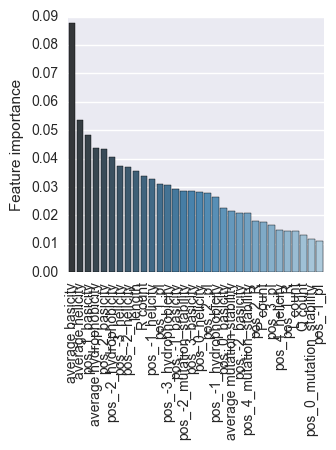

average basicity            0.087641
average helicity            0.053567
pos_1_basicity              0.048392
average hydrophobicity      0.043851
pos_2_basicity              0.043527
                              ...   
pos_1_R                     0.014522
L count                     0.014502
Q count                     0.013242
pos_0_mutation_stability    0.011811
pos_-1_pI                   0.010849
Name: Feature importances, dtype: float64
Classification accuracy = 96.87% ± 0.82%


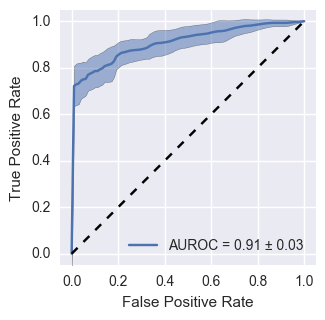

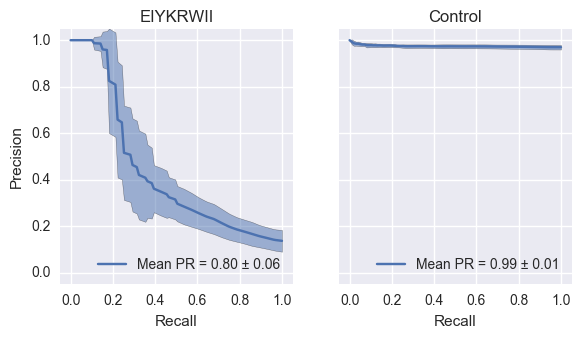

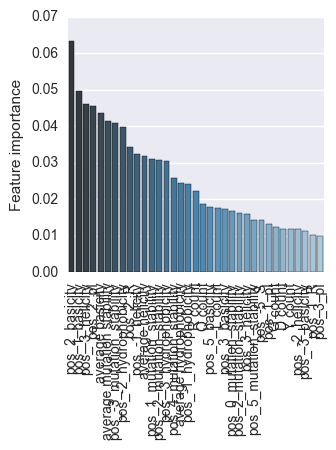

pos_2_basicity      0.063418
pos_1_basicity      0.049740
pos_-3_helicity     0.046117
pos_2_pI            0.045402
average basicity    0.043470
                      ...   
Y count             0.011849
pos_-2_helicity     0.011815
pos_-3_basicity     0.011173
pos_1_R             0.010075
pos_3_pI            0.010013
Name: Feature importances, dtype: float64
Classification accuracy = 96.36% ± 0.91%


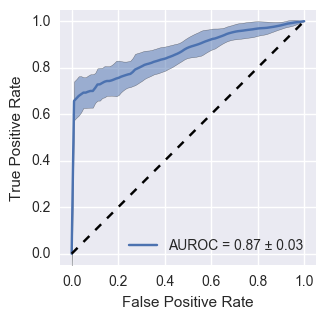

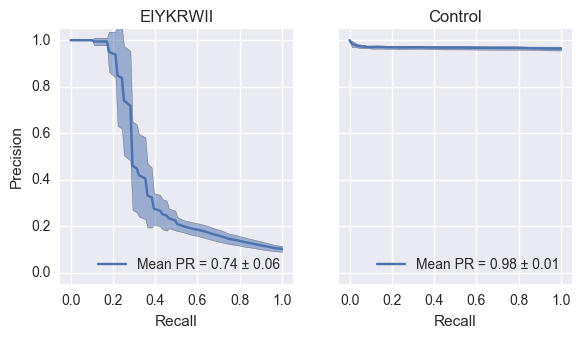

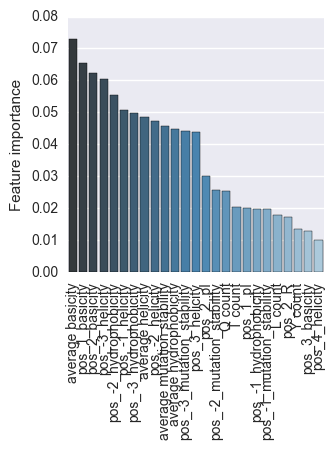

average basicity         0.072958
pos_1_basicity           0.065388
pos_2_basicity           0.062183
pos_-3_helicity          0.060389
pos_-2_hydrophobicity    0.055324
                           ...   
L count                  0.017835
pos_2_R                  0.017371
Y count                  0.013537
pos_3_basicity           0.012781
pos_4_helicity           0.010108
Name: Feature importances, dtype: float64
Classification accuracy = 97.25% ± 0.33%


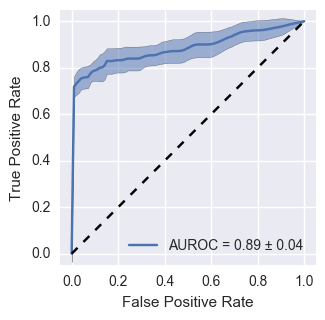

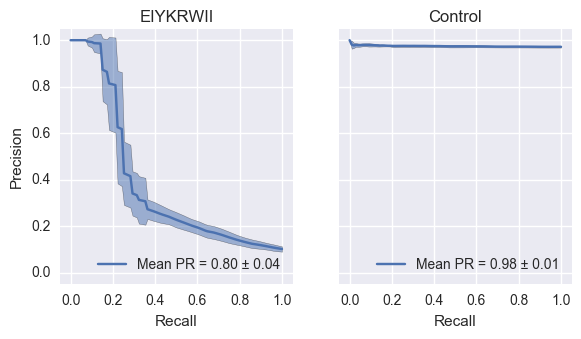

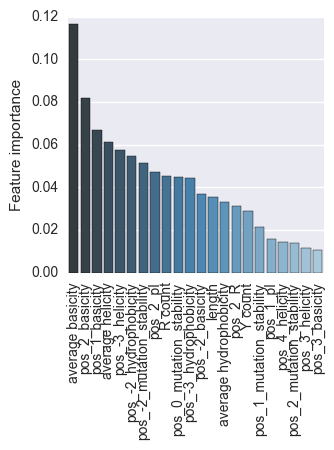

average basicity            0.116672
pos_2_basicity              0.081985
pos_1_basicity              0.066745
average helicity            0.061368
pos_-3_helicity             0.057522
                              ...   
pos_1_pI                    0.015757
pos_4_helicity              0.014138
pos_2_mutation_stability    0.013785
pos_3_helicity              0.011491
pos_3_basicity              0.010592
Name: Feature importances, dtype: float64
Classification accuracy = 97.32% ± 0.66%


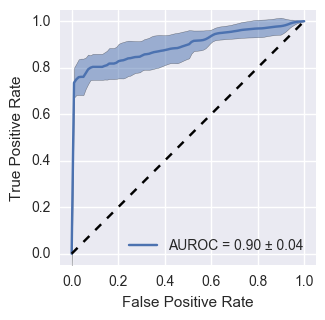

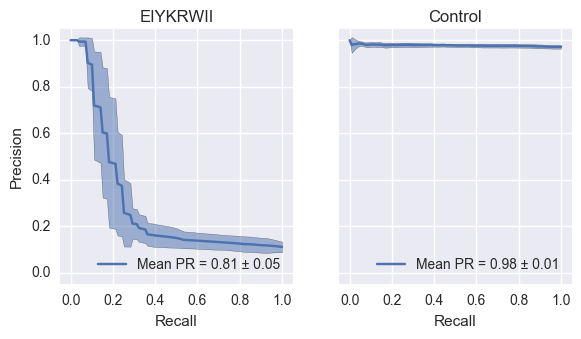

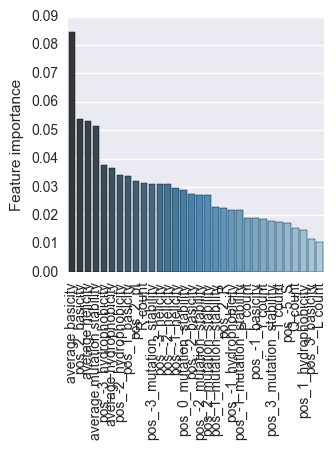

average basicity              0.084508
pos_2_basicity                0.054083
average helicity              0.053331
average mutation stability    0.051615
pos_-3_hydrophobicity         0.037682
                                ...   
pos_-5_S                      0.017231
Q count                       0.015742
pos_1_hydrophobicity          0.014986
pos_3_basicity                0.011536
L count                       0.010662
Name: Feature importances, dtype: float64
Classification accuracy = 97.32% ± 1.74%


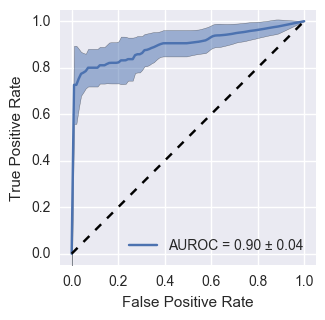

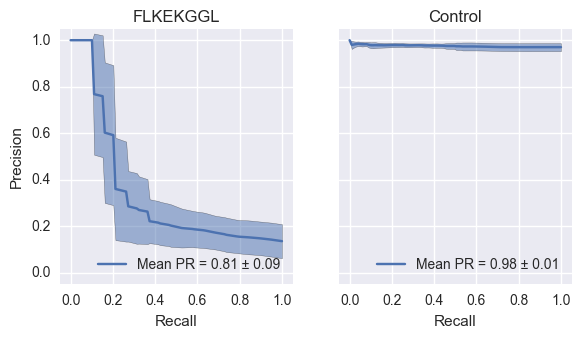

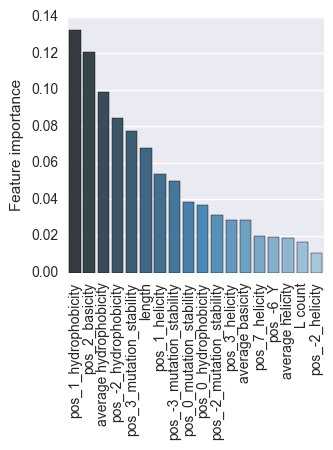

pos_1_hydrophobicity        0.132909
pos_2_basicity              0.120539
average hydrophobicity      0.098701
pos_-2_hydrophobicity       0.084463
pos_3_mutation_stability    0.077209
                              ...   
pos_7_helicity              0.019740
pos_-6_Y                    0.019239
average helicity            0.018693
L count                     0.016864
pos_-2_helicity             0.010698
Name: Feature importances, dtype: float64
Classification accuracy = 97.13% ± 0.93%


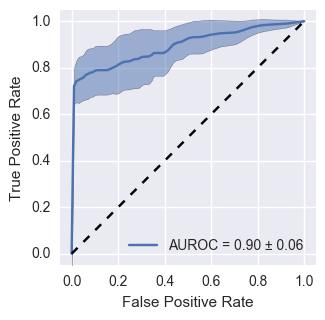

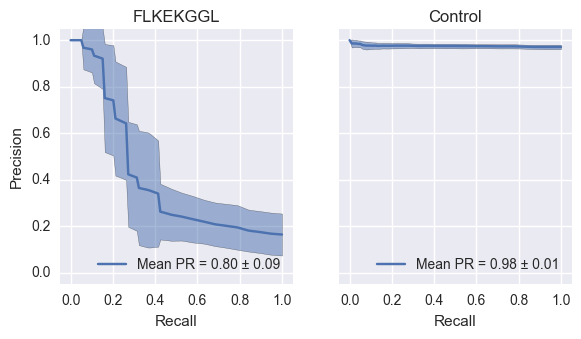

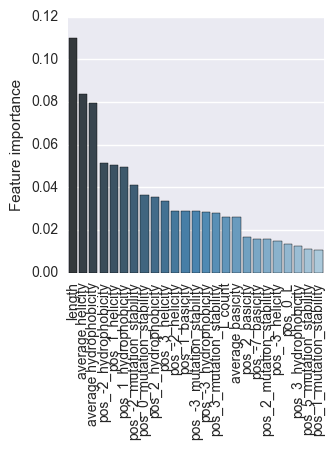

length                      0.110259
average helicity            0.083933
average hydrophobicity      0.079352
pos_-2_hydrophobicity       0.051357
pos_1_helicity              0.050529
                              ...   
pos_-3_helicity             0.014711
pos_0_L                     0.013580
pos_3_hydrophobicity        0.012567
pos_5_mutation_stability    0.011141
pos_1_mutation_stability    0.010709
Name: Feature importances, dtype: float64
Classification accuracy = 97.32% ± 0.68%


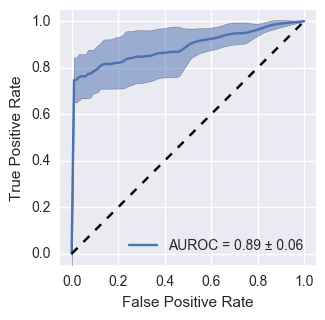

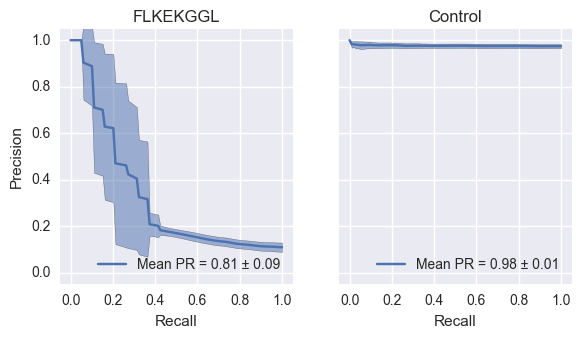

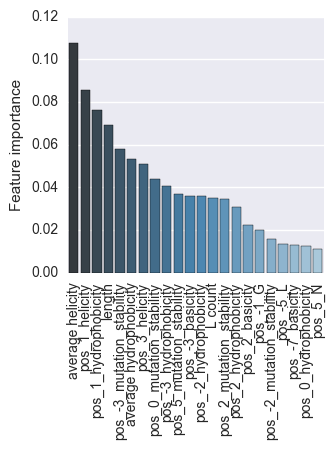

average helicity             0.107592
pos_1_helicity               0.085676
pos_1_hydrophobicity         0.076428
length                       0.069100
pos_-3_mutation_stability    0.057729
                               ...   
pos_-2_mutation_stability    0.015766
pos_-5_L                     0.013395
pos_-7_basicity              0.012980
pos_0_hydrophobicity         0.012617
pos_5_N                      0.010910
Name: Feature importances, dtype: float64
Classification accuracy = 96.70% ± 1.10%


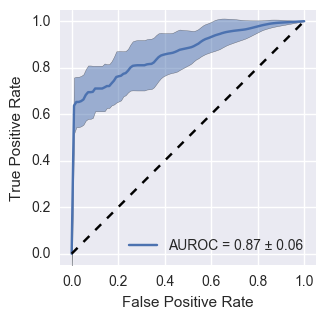

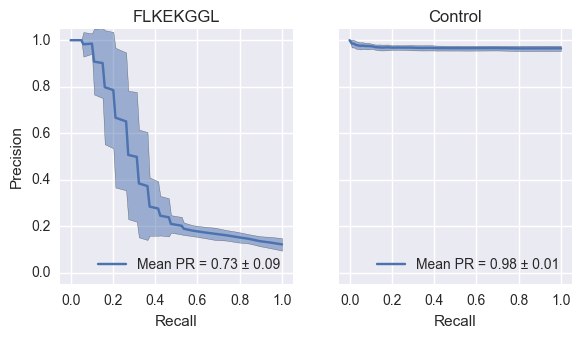

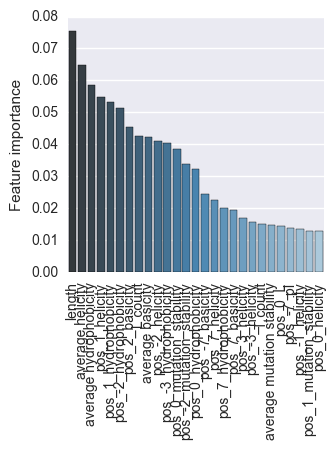

length                      0.075457
average helicity            0.064918
average hydrophobicity      0.058510
pos_1_helicity              0.054731
pos_1_hydrophobicity        0.053232
                              ...   
pos_0_L                     0.014507
pos_-7_pI                   0.013749
pos_-1_helicity             0.013605
pos_1_mutation_stability    0.012982
pos_0_helicity              0.012880
Name: Feature importances, dtype: float64
Classification accuracy = 97.51% ± 0.90%


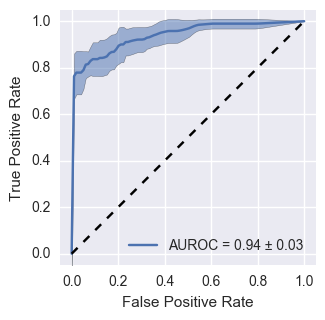

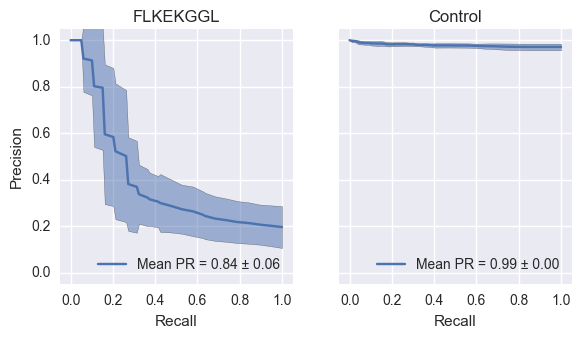

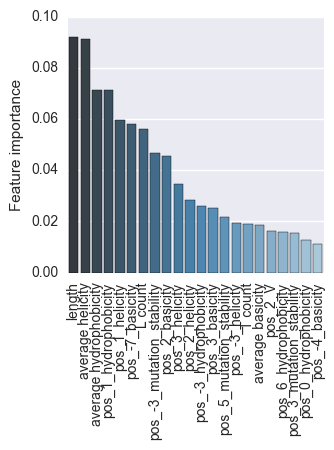

length                      0.092133
average helicity            0.091179
average hydrophobicity      0.071522
pos_1_hydrophobicity        0.071180
pos_1_helicity              0.059543
                              ...   
pos_2_V                     0.016406
pos_6_hydrophobicity        0.015827
pos_3_mutation_stability    0.015474
pos_0_hydrophobicity        0.012673
pos_-4_basicity             0.011153
Name: Feature importances, dtype: float64


In [59]:
# number of StratifiedShuffleSplit repeats within one subsample
repeats = 10

for peptide, X_subsample, y_subsample in splitframes:

    # turn off numpy RuntimeWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        X = X_subsample.values
        y = y_subsample.values
        
        y = preprocessing.LabelEncoder().fit_transform(y)
        
        # do multiple splits to get a more accurate evaluation of the performance
        sss = model_selection.StratifiedShuffleSplit(n_splits=repeats, test_size=0.2, random_state=0)
        
        result = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_predictor)
                                                       (predictor, X, y, train_index, test_index)
                                                       for train_index, test_index in sss.split(X, y)))
        predictions = result[:, 0]
        predictions_proba = result[:, 1]
        feature_importances = result[:, 2]

        # evaluate the performance of the prediction pipeline
        # accuracy
        accuracy_mean = np.mean([metrics.accuracy_score(y_test, y_pred)
                                 for y_test, y_pred in predictions])
        accuracy_std = np.std([metrics.accuracy_score(y_test, y_pred)
                               for y_test, y_pred in predictions])

        # AUC and average precision
        auc_mean = np.mean([metrics.roc_auc_score(y_test, y_pred)
                            for y_test, y_pred in predictions_proba])
        auc_std = np.std([metrics.roc_auc_score(y_test, y_pred)
                          for y_test, y_pred in predictions_proba])
        avg_precision_mean = np.mean([metrics.average_precision_score(y_test, y_pred)
                                      for y_test, y_pred in predictions_proba])
        avg_precision_std = np.std([metrics.average_precision_score(y_test, y_pred)
                                    for y_test, y_pred in predictions_proba])
        avg_precision_inverted_mean = np.mean([metrics.average_precision_score(1 - y_test, 1 - y_pred)
                                               for y_test, y_pred in predictions_proba])
        avg_precision_inverted_std = np.std([metrics.average_precision_score(1 - y_test, 1 - y_pred)
                                             for y_test, y_pred in predictions_proba])

        # mean and standard deviation of ROC and precision-recall curves
        interval = np.linspace(0, 1, 100)
        tprs, precisions, precisions_inverted = [], [], []
        for y_test, y_pred in predictions_proba:
            fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
            tprs.append(np.interp(interval, fpr, tpr))

            precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
            precisions.append(np.interp(interval, recall[::-1], precision))

            # inverted precision
            precision_inverted, recall_inverted, _ = metrics.precision_recall_curve(1 - y_test, 1 - y_pred)
            precisions_inverted.append(np.interp(interval, recall_inverted[::-1], precision_inverted))
            
        tpr_mean = np.mean(tprs, axis=0)
        tpr_mean[0], tpr_mean[-1] = 0.0, 1.0
        tpr_std = np.std(tprs, axis=0)
        precision_mean = np.mean(precisions, axis=0)
        precision_std = np.std(precisions, axis=0)
        precision_inverted_mean = np.mean(precisions_inverted, axis=0)
        precision_inverted_std = np.std(precisions_inverted, axis=0)

        # print accuracy
        print('Classification accuracy = {:.2%} ± {:.2%}'.format(accuracy_mean, accuracy_std))

        # plot ROC curve
        width, height = 3.3, 3.3

        plt.figure(figsize=(width, height))

        plt.plot(interval, tpr_mean, label='AUROC = {:.2f} ± {:.2f}'.format(auc_mean, auc_std))
        plt.fill_between(interval, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.5)

        plt.plot([0, 1], [0, 1], 'k--')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

        plt.legend(loc='lower right')

        plt.gca().set_aspect('equal', adjustable='box')

        plt.savefig('AUC.pdf', bbox_inches='tight', dpi=600)

        plt.show()
        plt.close()

        # plot precision-recall curve
        plt.figure(figsize=(2 * width, height))

        ax1 = plt.subplot(121)
        ax1.set_title(peptide)
        plt.plot(interval[::-1], precision_mean,
                 label='Mean PR = {:.2f} ± {:.2f}'.format(avg_precision_mean, avg_precision_std))
        plt.fill_between(interval[::-1], precision_mean - precision_std, precision_mean + precision_std,
                         alpha=0.5)
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower right')

        ax2 = plt.subplot(122, sharey=ax1)
        plt.setp(ax2.get_yticklabels(), visible=False)
        ax2.set_title('Control')
        plt.plot(interval[::-1], precision_inverted_mean,
                 label='Mean PR = {:.2f} ± {:.2f}'.format(avg_precision_inverted_mean, avg_precision_inverted_std))
        plt.fill_between(interval[::-1], precision_inverted_mean - precision_inverted_std,
                         precision_inverted_mean + precision_inverted_std, alpha=0.5)
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('Recall')
        plt.legend(loc='lower right')

        plt.savefig('PR.pdf', bbox_inches='tight', dpi=600)

        plt.show()
        plt.close()
        
        feat_import_s = pd.Series(np.mean(feature_importances, axis=0),
                                  index=X_subsample.columns.values, name='Feature importances')
        significant_features = feat_import_s[feat_import_s > 0.01].sort_values(ascending=False)
        
        plt.figure(figsize=(width, height))

        sns.barplot(x=significant_features.index.values, y=significant_features, palette='Blues_d')

        plt.xticks(rotation='vertical', fontsize=10)
        plt.ylabel('Feature importance')

        plt.savefig('feature_importance.pdf', bbox_inches='tight', dpi=600)
        plt.show()
        plt.close()
        print(significant_features)